<a href="https://colab.research.google.com/github/JamesKevinStar/CalcularDistanciaCamara-Objeto/blob/main/Algoritmo%20Pinehol/Aplicar_Algoritmo_de_Pinehol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicativo para hallar la distancia de la cámara al objeto**
```
Estudiante : James Kevin Estrella Vilca
Propósito  : Implementación de un aplicativo usando el algoritmo Pinehol
Universidad: Universidad Nacional de San Antonio Abad del Cusco
```

###***NOTA*** : 

Para poder realizar las consultas sobre la altura real del objeto detectado se necesita tener una cuenta en OpenAI.

Con la cuenta establecida, se puede pedir que te genere una clave, la cual se tendrá que ingresar en el módulo "Obtener_Altura", en la parte que se indique.

- Ir a la página oficial de OpenAI :
https://openai.com/

- Ir al apartado "API"

- Logearse o Registrarse (En caso no tenga una cuenta creada), al logearse se le mandará a otra página.

- Hacer click al apartado "Upgrade"

- Buscar en la parte izquierda el apartado "USER" y hacer click en "API Keys"

- Dar click al botón "Create new secret key" y guardar la clave creada

- Usar esa clave creada en el módulo mencionado anteriormente

# 1. Importar e Instalar Librerías

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 KB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai: filename=openai-0.26.4-py3-none-any.whl size=67744 sha256=98331ed92f7038d08cdc5e4a0f6a690a75647485883ae73b4bf91ec295b6c4bb
  Stored in directory: /root/.cache/pip/wheels/2b/d8/4e/268f029bd3277c1dd9e8781a0e0296e0a63822665bfa2429fc
Successfully built openai


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import openai
import cv2
import re

from tensorflow import keras

# 2. Obtener el tamaño promedio en pixeles del objeto detectado en la imagen

In [ ]:
def Obtener_Altura_Imagen(Ruta):
    image = cv2.imread(Ruta)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imageCopy = image.copy()
    print("Imagen original")
    plt.imshow(imageCopy)
    plt.show()
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    print("Imagen en tono de grises")
    plt.imshow(gray_image, cmap = "gray")
    plt.show()
    
    ret, binary_im = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    print("Imagen en binario")
    plt.imshow(binary_im, cmap = "gray")
    plt.show()

    contours, hierarchy = cv2.findContours(binary_im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_to_plot = -1
    plotting_color = (0, 255, 0)

    thickness = -1
    with_contours = cv2.drawContours(image, contours, contours_to_plot, plotting_color, thickness)

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
    print("Imagen con todos los contorno detectados")
    plt.imshow(image)
    plt.show()

    required_contour = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(required_contour)
    img_copy2 = cv2.rectangle(imageCopy, (x, y), (x + w, y + h), (0, 255, 255), 2)
    print("Imagen con contorno principal")
    plt.imshow(img_copy2)
    plt.show()

    new_img = imageCopy[y:y+h, x:x+w]
    print("Imagen recortada")
    plt.imshow(new_img)
    plt.show()

    return h, new_img

# 3. Reconocer qué objeto es el detectado anteriormente

In [ ]:
def Reconocer_Objeto(Imagen):
    new_img = cv2.resize(Imagen, (224, 224))
    model = keras.applications.MobileNetV2(weights = 'imagenet')
    img = keras.preprocessing.image.img_to_array(new_img)
    x = keras.preprocessing.image.img_to_array(img)
    x = tf.expand_dims(x, 0)
    x = keras.applications.mobilenet_v2.preprocess_input(x)

    preds = model.predict(x)
    pred_class = keras.applications.mobilenet_v2.decode_predictions(preds, top = 1)
    Predicción = pred_class[0][0][1]
    print("\n")
    print("Clase predicha: {}".format(Predicción))
    
    return Predicción

# 4. Obtener la altura en metros de la predicción del posible objeto en la imagen

In [ ]:
def Obtener_Altura(Prediccion):
    # ====================================================================
    openai.api_key = "Ingresar su Clave OpenAI" # Aquí se coloca su clave para usar la API.
    # ====================================================================
    prompt = (f"Give me only the height of " + Prediccion + " in meters, no text")
    response = openai.Completion.create(engine = "text-davinci-003", prompt = prompt, max_tokens = 100)
    Respuesta = response["choices"][0]["text"]
    print("\n")
    print("Respuesta obtenida: {}".format(Respuesta))
    
    Alturas = list(map(float, re.findall(r"[-+]?\d*\.\d+|\d+", Respuesta)))
    Promedio = np.mean(Alturas)
    print("\n")
    print("Altura real promedio: {}".format(Promedio))
    
    return Promedio

# 5. Módulo que utiliza el algoritmo de Pinehol para hallar la distancia promedio

In [ ]:
def Calcular(DPI, f, Ruta_Imagen):
    Altura_Px, Imagen = Obtener_Altura_Imagen(Ruta_Imagen)
    Predicción = Reconocer_Objeto(Imagen)
    Altura_Real = Obtener_Altura(Predicción)
    Pixel_Cm = 2.54/DPI*Altura_Px
    print("\n")
    print("Distancia desde la cámara hasta el objeto es aproximadamente: {} m".format(Altura_Real/(Pixel_Cm/100)*(f/1000)))

# 6. Ingresar las especificaciones técnicas de la cámara y la imagen

Imagen original


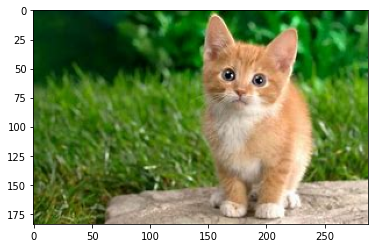

Imagen en tono de grises


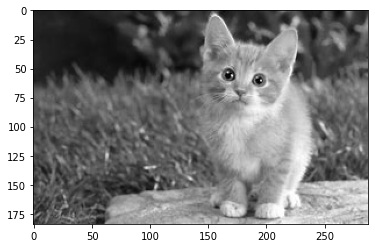

Imagen en binario


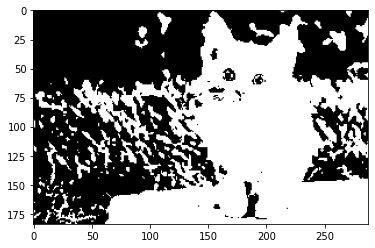

Imagen con todos los contorno detectados


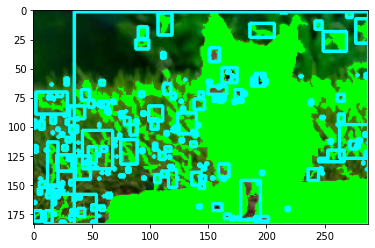

Imagen con contorno principal


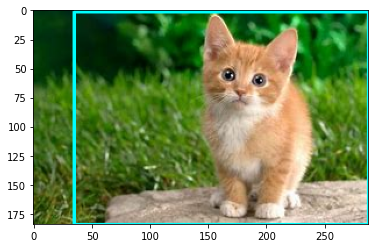

Imagen recortada


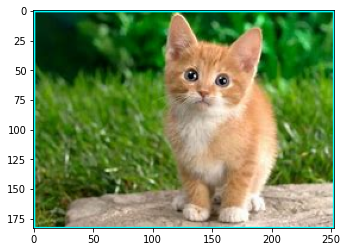

1/1 [==============================] - 1s 722ms/step


Clase predicha: Egyptian_cat


Respuesta obtenida: 

0.25 m


Altura real promedio: 0.25


Distancia desde la cámara hasta el objeto es aproximadamente: 0.1445720924228734 m


In [ ]:
#@markdown Escoger el valor de DPI de su Dispositivo
DPI = 96 #@param {type:"slider", min:50, max:600, step:1}
#@markdown Distancia Focal en Milímetros de su Dispositivo
f = 28 #@param {type:"slider", min:14, max:300, step:1}
#@markdown Insertar el Nombre de la Imagen y Formato
Imagen = "Gato.jpeg" #@param {type:"string"}






Calcular(DPI, f, Imagen)